In [1]:
# default_exp test

# Import

In [24]:
# export
import numpy as np
from scipy.stats import multivariate_normal

from camera_calib_python.cb_geom import *
from camera_calib_python.control_refine import OpenCVCheckerRefiner
from camera_calib_python.utils import *

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

from camera_calib_python.control_refine import checker_opencv
from camera_calib_python.fiducial_detect import DotVisionCheckerDLDetector
from camera_calib_python.image import File16bitImg

# Test

Get calibration board geometry

In [4]:
h_cb = 50.8
w_cb = 50.8
h_f = 42.672
w_f = 42.672
num_c_h = 16
num_c_w = 16
spacing_c = 2.032

In [5]:
cb_geom = CbGeom(h_cb, w_cb,
                 CpCSRGrid(num_c_h, num_c_w, spacing_c),
                 FmCFPGrid(h_f, w_f))

In [6]:
ps_f_w = cb_geom.ps_f
ps_c_w = cb_geom.ps_c
bs_c_w = cb_geom.bs_c

Detect fiducial markers

In [7]:
file_model = Path('/home/justin/justinblaber/camera_calib_python/models/dot_vision_checker.pth')
file_img = Path('data/dot_vision_checker/SERIAL_16276942_DATETIME_2019-06-07-00:38:48-109736_CAM_3_FRAMEID_0_COUNTER_2.png')

In [8]:
img = File16bitImg(file_img)

In [9]:
ps_f_detector = DotVisionCheckerDLDetector(file_model)

In [10]:
ps_f_p = ps_f_detector(img)

Estimate homography

In [11]:
# export
def homography(ps1, ps2):    
    # Condition and augment points
    (ps1_cond, T1), (ps2_cond, T2) = map(condition, [ps1, ps2])
    ps1_cond, ps2_cond = map(augment, [ps1_cond, ps2_cond])
    
    # Form homogeneous system
    L = np.r_[np.c_[ps1_cond, np.zeros_like(ps1_cond), -ps2_cond[:, 0:1]*ps1_cond],
              np.c_[np.zeros_like(ps1_cond), ps1_cond, -ps2_cond[:, 1:2]*ps1_cond]]
    
    # Solution is the last row of V
    _,_,V = np.linalg.svd(L)
    H12_cond = V[-1, :].reshape(3,3)
    
    # Undo conditioning
    H12 = np.linalg.inv(T2)@H12_cond@T1
    H12 /= H12[2,2] # Sets H12[2,2] to 1
    return H12

In [12]:
H_init = homography(ps_f_w, ps_f_p)
H_init

array([[ 1.08005286e+00, -1.84333327e+01,  5.70068894e+02],
       [ 1.96498664e+01, -1.30037589e-01,  9.13011954e+02],
       [ 1.23962123e-03,  6.10272613e-04,  1.00000000e+00]])

In [13]:
ps_c_p = normalize(pmm(H_init, augment(ps_c_w)))

In [14]:
bs_c_p = np.array([normalize(pmm(H_init, augment(b_c_w))) for b_c_w in bs_c_w], np.object)

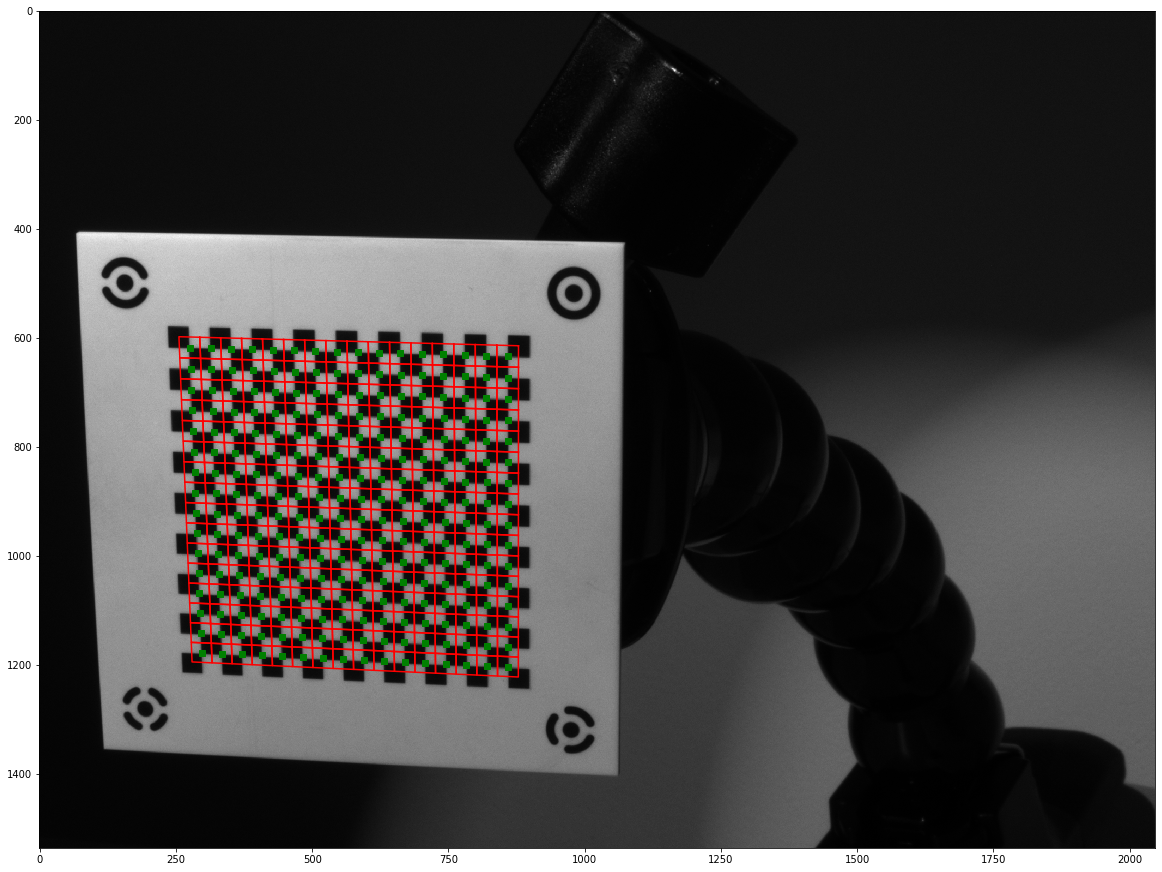

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(img.array_gs, cmap='gray')
plt.plot(ps_c_p[:,0], ps_c_p[:,1], 'gs')
for b_c_p in bs_c_p:
    plt.plot(np.r_[b_c_p[:,0],b_c_p[0,0]], np.r_[b_c_p[:,1],b_c_p[0,1]],'r')

In [16]:
arr = img.array_gs
arr_dx, arr_dy = grad_array(arr)

In [17]:
ps_c_p[0], bs_c_p[0]

(array([858.7428864 , 633.38643518]),
 array([[878.5844935448612, 614.1667623245968],
        [838.8941064355354, 613.1104586040717],
        [838.9778791064288, 652.5319092059557],
        [878.5655638183706, 653.6357474223086]], dtype=object))

In [18]:
refiner = OpenCVCheckerRefiner(hw_min=3, hw_max=10, cutoff_it=20, cutoff_norm=1e-3)

In [19]:
ps_c_p = refiner.refine_points(arr, ps_c_p, bs_c_p)

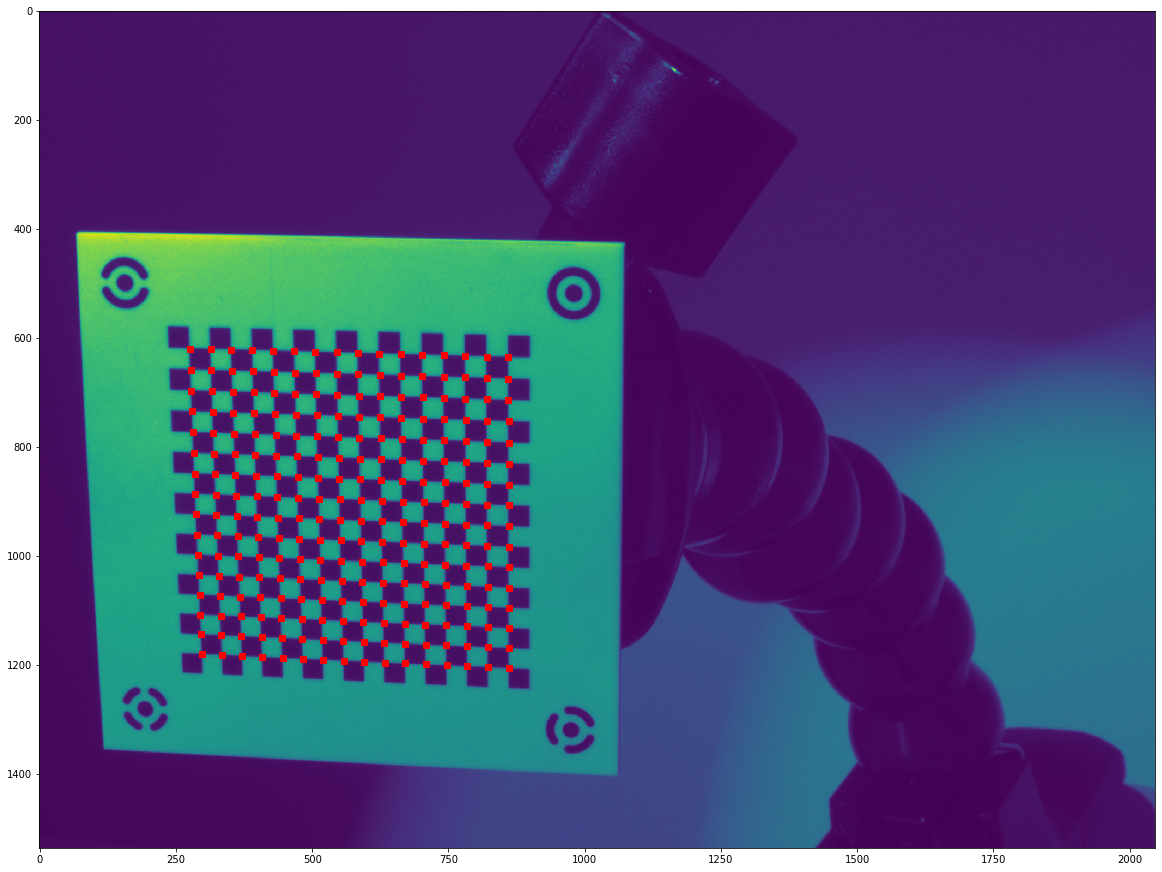

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(img.array_gs)
plt.plot(ps_c_p[:,0], ps_c_p[:,1],'rs')

In [66]:
num_h = 55
num_w = 55
spacing = 25
fo = True

In [67]:
h, w = (num_h-1)*spacing, (num_w-1)*spacing
xs_grid = np.linspace(-w/2, w/2, num_w)
ys_grid = np.linspace(-h/2, h/2, num_h)

In [68]:
xs_grid, ys_grid

(array([-675., -650., -625., -600., -575., -550., -525., -500., -475.,
        -450., -425., -400., -375., -350., -325., -300., -275., -250.,
        -225., -200., -175., -150., -125., -100.,  -75.,  -50.,  -25.,
           0.,   25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.,
         225.,  250.,  275.,  300.,  325.,  350.,  375.,  400.,  425.,
         450.,  475.,  500.,  525.,  550.,  575.,  600.,  625.,  650.,
         675.]),
 array([-675., -650., -625., -600., -575., -550., -525., -500., -475.,
        -450., -425., -400., -375., -350., -325., -300., -275., -250.,
        -225., -200., -175., -150., -125., -100.,  -75.,  -50.,  -25.,
           0.,   25.,   50.,   75.,  100.,  125.,  150.,  175.,  200.,
         225.,  250.,  275.,  300.,  325.,  350.,  375.,  400.,  425.,
         450.,  475.,  500.,  525.,  550.,  575.,  600.,  625.,  650.,
         675.]))

In [100]:
ps = np.empty((0,2))
for x_grid in xs_grid:
    if fo:
        ys = ys_grid[0::2]
        fo = False
    else:
        ys = ys_grid[1::2]
        fo = True
    ps = np.r_[ps, np.c_[np.tile(x_grid, len(ys)), ys]]

In [101]:
ps

array([[-675., -675.],
       [-675., -625.],
       [-675., -575.],
       ...,
       [ 675.,  575.],
       [ 675.,  625.],
       [ 675.,  675.]])

In [102]:
idx_remove = np.array([
   0,    1,   28,   55,  281,  282,  308,  309,  310,  335,  336,
 337,  338,  363,  364,  365,  390,  391,  392,  393,  418,  419,
 420,  446,  447,   26,   27,   54,   82,  295,  296,  322,  323,
 324,  349,  350,  351,  352,  377,  378,  379,  404,  405,  406,
 407,  432,  433,  434,  460,  461, 1430, 1458, 1485, 1486, 1051,
1052, 1078, 1079, 1080, 1105, 1106, 1107, 1108, 1133, 1134, 1135,
1160, 1161, 1162, 1163, 1188, 1189, 1190, 1216, 1217, 1457, 1484,
1511, 1512, 1065, 1066, 1092, 1093, 1094, 1119, 1120, 1121, 1122,
1147, 1148, 1149, 1174, 1175, 1176, 1177, 1202, 1203, 1204, 1230,
1231
])

In [118]:
np.empty(0, dtype=np.int)

TypeError: Required argument 'shape' (pos 1) not found

In [113]:
np.delete(ps, np.empty(0, dtype=np.int), axis=0).shape

(1413, 2)

In [103]:
ps.shape

(1513, 2)

In [104]:
ps = np.delete(ps, idx_remove, axis=0)

In [105]:
ps.shape

(1413, 2)

In [115]:
ps_f = cfpgrid(700, 700)

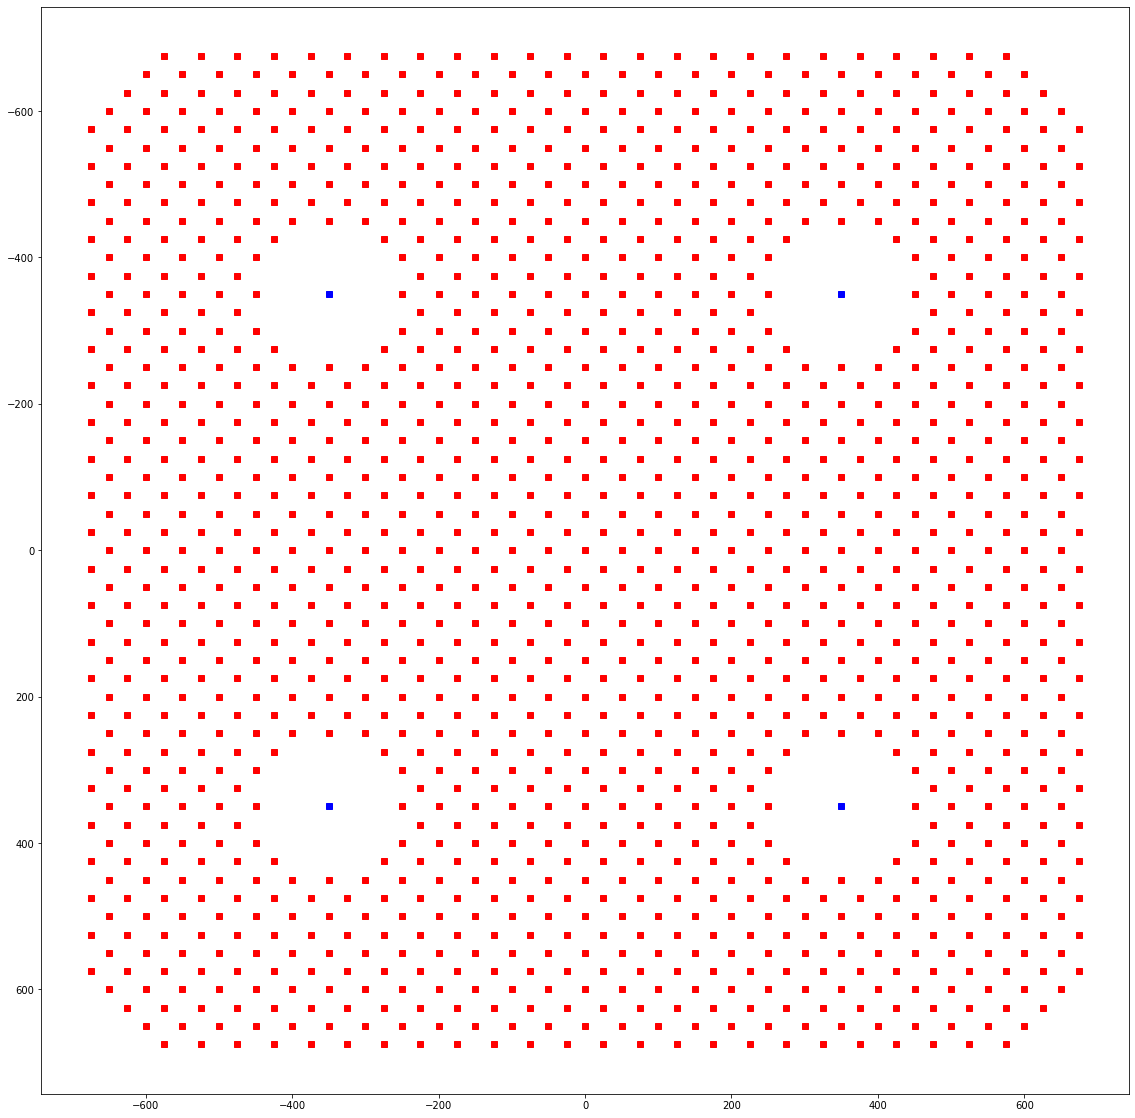

In [117]:
plt.figure(figsize=(20,20))
plt.plot(ps[:,0], ps[:,1], 'rs')
plt.plot(ps_f[:,0], ps_f[:,1], 'bs')
#for idx, p in enumerate(ps): plt.text(p[0], p[1], str(idx))
plt.gca().set_aspect(1)
plt.gca().invert_yaxis()

# Build

In [21]:
!nbdev_build_lib

Converted cb_geom.ipynb.
Converted control_refine.ipynb.
Converted coordinate_graph.ipynb.
Converted fiducial_detect.ipynb.
Converted image.ipynb.
Converted modules.ipynb.
Converted test.ipynb.
Converted utils.ipynb.
